In [1]:
#Importing necessary libraries
from model import SCUNet
import torch
import librosa
from transforms import Normalize, HorizontalCrop
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import os
import IPython.display as ipd

In [2]:
#Loading and taking STFT of mixture
mixture, sr = librosa.load('./Dataset/Mix/Mix3.wav')
resampled_mixture = librosa.resample(mixture, sr, 8192)
mixture_stft = librosa.stft(resampled_mixture, n_fft=1024, hop_length=768, window='hann', center=True)
magnitude_mixture_stft, mixture_phase = librosa.magphase(mixture_stft)

In [3]:
#Pre-processing of mixture
cropped_magnitude_mixture_stft = HorizontalCrop(449).forward([magnitude_mixture_stft])[0]
normalized_magnitude_mixture_stft = torch.Tensor(Normalize().forward([cropped_magnitude_mixture_stft])[0])
(normalized_magnitude_mixture_stft > 1).any()
normalized_magnitude_mixture_stft.shape

torch.Size([513, 449])

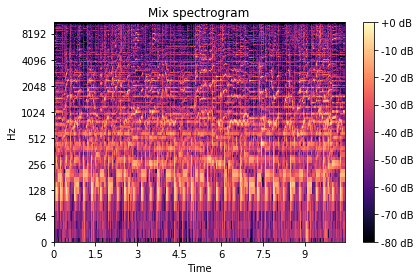

In [4]:
#Plotting Spectrogram
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(cropped_magnitude_mixture_stft,
                                                 ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Mix spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [5]:
#Loading and taking STFT of first source
vocal, sr_v = librosa.load('./Dataset/Sources/vocals3.wav')
resampled_vocal = librosa.resample(vocal, sr_v, 8192)
vocal_stft = librosa.stft(resampled_vocal, n_fft=1024, hop_length=768, window='hann', center=True)
magnitude_vocal_stft, vocal_phase = librosa.magphase(vocal_stft)

In [6]:
#Pre-processing of Vocal
cropped_magnitude_vocal_stft = HorizontalCrop(449).forward([magnitude_vocal_stft])[0]
normalized_magnitude_vocal_stft = torch.Tensor(Normalize().forward([cropped_magnitude_vocal_stft])[0])
(normalized_magnitude_vocal_stft > 1).any()

tensor(0, dtype=torch.uint8)

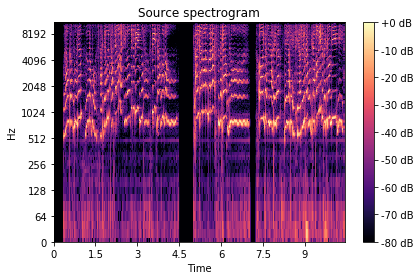

In [7]:
#Plotting Spectrogram of the Vocal
librosa.display.specshow(librosa.amplitude_to_db(cropped_magnitude_vocal_stft,
                                                 ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Source spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [8]:
#Setting up pre-trained model
model = SCUNet.Generator(1)
model_weights = torch.load('./interrupted_generator_4tracks_leaky_v3.pt')
model.load_state_dict(model_weights)

In [9]:
#Prediction with the model
model.eval()
with torch.no_grad():
    mask = model.forward(normalized_magnitude_mixture_stft.unsqueeze(0)).squeeze(0)
    out = mask * torch.Tensor(cropped_magnitude_mixture_stft)

In [8]:
true_mask = cropped_magnitude_vocal_stft/cropped_magnitude_mixture_stft

In [16]:
(true_mask>6).sum()/len(true_mask)

1.0019493177387915

/home/karlos/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 42080.0)

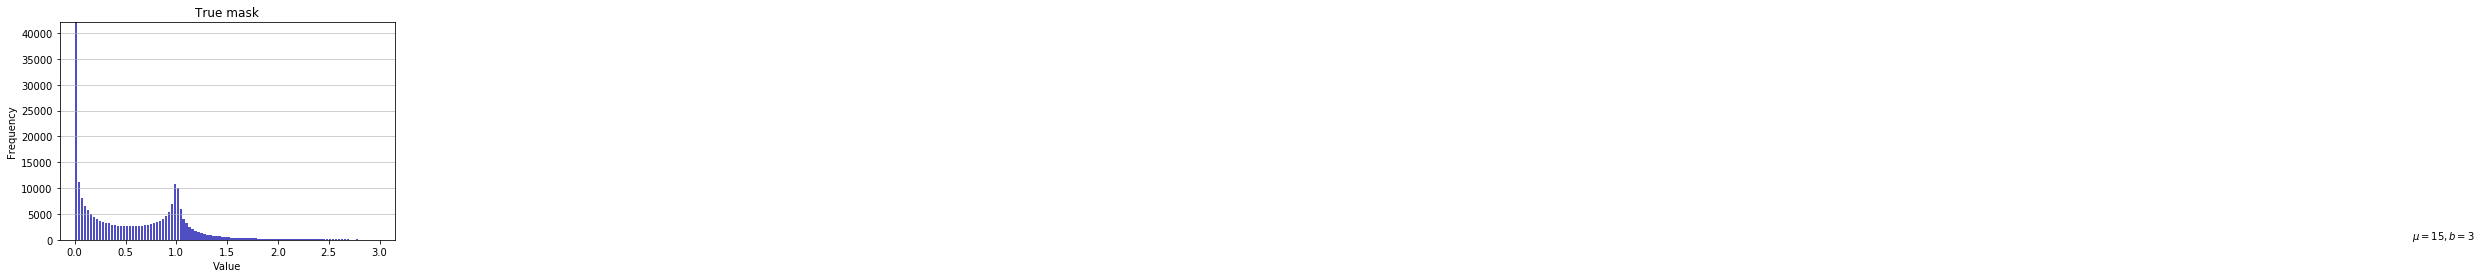

In [12]:
# ========================================================= #
# Processing

flattened = (true_mask).reshape((-1))
n, bins, patches = plt.hist(x=flattened[flattened<3], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('True mask')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 54860.0)

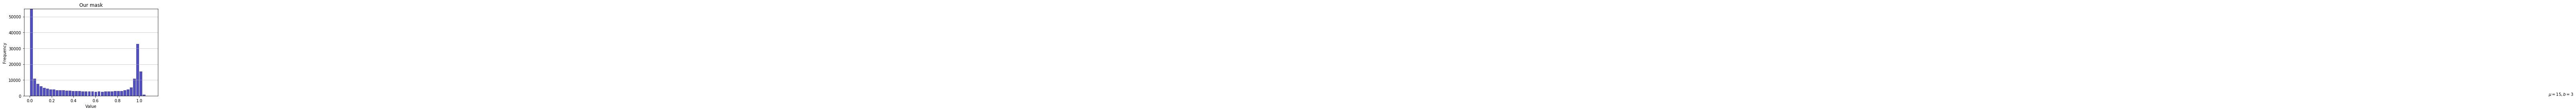

In [13]:
# ========================================================= #
# Processing

mask = (mask).reshape((-1))
n, bins, patches = plt.hist(x=mask[mask<3], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Our mask')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [26]:
#Loading and taking STFT of mixture
mixture, sr = librosa.load('./Dataset/Mix/Mix3.wav')
mixture_stft = librosa.stft(mixture, n_fft=1024, hop_length=768, window='hann', center=True)

In [14]:
predicted_vocal_audio = librosa.istft(mixture_stft, win_length=1024,hop_length=768,window='hann',center='True')
ipd.Audio(predicted_vocal_audio, rate=sr)